In [4]:
import matplotlib
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import math
import tqdm as tq
from tinygrad.nn.datasets import mnist
from matplotlib import pyplot as plt

In [3]:
X_train, Y_train, X_test, Y_test = mnist()
X_train = X_train.reshape(-1, 784).numpy().astype(np.float32)
Y_train = Y_train.numpy().astype(np.int8)
X_test = X_test.reshape(-1, 784).numpy().astype(np.float32)
Y_test = Y_test.numpy().astype(np.int8)

In [5]:
#model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(784, 128, bias=False)
        self.lay2 = nn.Linear(128, 10, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = self.lay2(x)
        return x
model = Model()

loss 25.92 accuracy 0.06
loss 0.67 accuracy 0.86
loss 0.42 accuracy 0.87
loss 0.30 accuracy 0.92
loss 0.35 accuracy 0.91
loss 0.34 accuracy 0.91
loss 0.18 accuracy 0.94
loss 0.16 accuracy 0.96
loss 0.43 accuracy 0.92
loss 0.32 accuracy 0.93


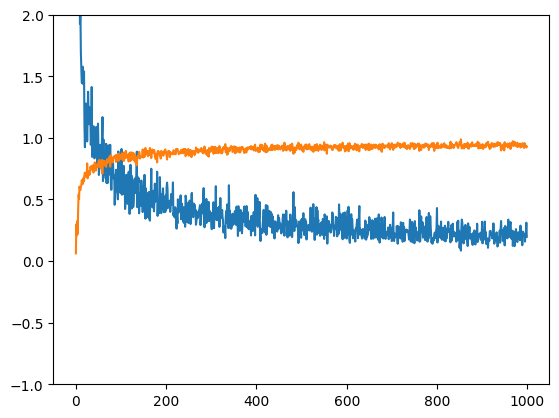

In [6]:
#training
optim = t.optim.SGD(model.parameters(),lr = .001, momentum = 0)
batch_size = 256
loss_func = nn.CrossEntropyLoss()
losses, accuracies = [], []
for k in range(1000):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = t.tensor(X_train[samp])
    Y = t.tensor(Y_train[samp]).long()

    optim.zero_grad() #reset gradients
    out = model(X) #forward pass
    cat = t.argmax(out, dim=1) 
    #print("cat",cat.shape)
    accuracy = (cat == Y).float().mean() #check how many are right
    #run backprop
    loss = loss_func(out, Y)

    loss.backward()
    #do grad descent 
    
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    accuracies.append(accuracy)
    losses.append(loss)
    if k % 100 == 0:
        print("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-1,2)
plt.plot(losses)
plt.plot(accuracies)

In [9]:
#model evaluation
out = model(t.tensor(X_test))
cat = t.argmax(out, dim=1)
accuracy = (cat == t.tensor(Y_test)).float().mean()
accuracy

tensor(0.9351)

In [10]:
#try w/ numpy 
#create model
#network 
l1 = np.zeros((784, 128),dtype=np.float32) #containing weights
l2 = np.zeros((128, 10),dtype=np.float32) 


In [11]:
#copy weights from pytorch lol
lay1 = model.lay1.weight.detach().numpy().T
lay2 = model.lay2.weight.detach().numpy().T

In [12]:
#numpy forward pass
def forward(x):
    x = x.dot(lay1) #first layer
    x = np.maximum(x,0) #relu
    x = x.dot(lay2) #second layer
    return x

In [13]:
pred = forward(X_test).argmax(axis=1)
accuracy = (pred == Y_test).mean()
print(f"test set accuracy is {accuracy}")

test set accuracy is 0.9351


In [208]:
#numpy from scratch😈
def layer_init(m,h):
    weights = np.random.uniform(-1.0,1.0,size=(m,h))/np.sqrt(m * h) #XAVIER WEIGHT INITIALIZATION!!!!
    return weights
w1 = layer_init(784,128)
w2 = layer_init(128,10)
X_train /= 255.0
X_test /= 255.0

In [231]:
def forward(x):
    #save each step of the nn, we will need for grad calculation
    x1 = x.dot(w1) #10000(or BS)x784 * 784x128 = 10000x128, x1 is the data points going out of each of the nodes in the first layer
    x2 = np.maximum(x1,0) #relu activation function on x1 data points, going into each of the 10 nodes of the second layer
    x3 = x2.dot(w2) #10000x128 * 128x10 = 10000x10, x3 is the outputs of the second layer
    #print("x3: ", x3)
    #make softmax
    exps = np.exp(x3 - np.max(x3, axis=1, keepdims=True))
    softmax = exps/(np.sum(exps,axis = 1,keepdims=True)) #to get a prob distribution
    
    return x, x1, x2, x3, softmax




In [206]:
def cross_entropy_loss(y_pred,y_targ):
    #turn Y_test to BS x 10 prob distribution
    actual = np.zeros((y_targ.shape[0],10)) 
    actual[np.arange(y_targ.shape[0]),y_targ] = 1
    loss = -np.mean(np.sum(actual * np.log(y_pred + 1e-8), axis=1))
    error = y_pred - actual #make sure u understand teh math behind this
    return loss, error


In [214]:
def backprop(loss,x0,x1,x2,x3,softmax,error):
    #go from the back
    # dx3 = error   #grad of softmax functions, y_pred - actual BSx10
    # dw2 = x2.T.dot(dx3)   #chain rule, dL/dw2 = dL/dz_2 (logits outputted by final layer) * dz_2/dw_2. z_2 = x2 * w_2, so second term = x2.T, first is
    # #what we just calculated. we have x2 which is BSx128, now 128xBS and dx3 = BSx10 multiplication results in 128x10
    # dx2 = dx3.dot(w2.T) #same concept, w2 is 128x10, dx3 = BSx10, we have  BSx10 * 10x128 = BSx128
    # dx1 = (x1 > 0).astype(np.float64) * dx2 #ReLU', which is just 1 if x > 0, 0 otherwise
    # dw1 = x0.T.dot(dx1) #x0 is BSx784 and dx1 is BSx128 -> 784x128
    dx3 = error   # grad of softmax functions, y_pred - actual
    #print("dx3 mean:", np.mean(dx3))
    
    dw2 = x2.T.dot(dx3)  # Gradient calculation for W2
    #print("dw2 mean:", np.mean(dw2))
    
    dx2 = dx3.dot(w2.T) 
    #print("dx2 mean:", np.mean(dx2))
    
    dx1 = (x1 > 0).astype(np.float64) * dx2 
    #print("dx1 mean:", np.mean(dx1))
    
    dw1 = x0.T.dot(dx1)  # Gradient calculation for W1
   # print("dw1 mean:", np.mean(dw1))
    #print(dw1)
    return dw2, dw1

    return dw1, dw2 #we can't change data after all
    

In [212]:
def SGD(dw1,dw2,lr=.1):
    #update w1
    global w1, w2
    ws = (w1,w2)
    dws = (dw1,dw2)
    for wi, dwi in zip(ws, dws):
        wi -= lr * dwi
    return ws
        

In [ ]:
batch_size = 256
for i in range(100):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = X_train[samp]
    print(X[0])
    Y = Y_train[samp]

    x,x1,x2,x3,softmax = forward(X)
    cat = np.argmax(softmax, axis=1) 
    #print("cat",cat.shape)
    accuracy = np.mean(cat == Y)
    loss, error = cross_entropy_loss(softmax,Y.astype(int))
    dw2,dw1 = backprop(loss,x,x1,x2,x3,softmax,error)
    #print(dw1[0][0:2])
    SGD(dw1,dw2)
    if i % 100 == 0:
        print("loss %.2f accuracy %.2f" % (loss, accuracy))


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000